# **Forecasting Temperature with `PyTS`**

**Main goal of the project:** 
>***Forecasting temperature in a accurate way using a Machine Learning general approach.***

  This part of the project will be focused in the following forecasting approaches: 

  - Univariate forecasting with recursive and direct forecasting strategies.

For each approach the best model will be found, applying ML evaluation techniques like cross Validation and hyper-parameter optimization.

**Author:** ***Fabio Scielzo Ortiz***

### **Requirements**

In [1]:
import polars as pl 
import pandas as pd 
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
from statsmodels.tsa.seasonal import STL
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import timedelta
from sklearn.metrics import mean_absolute_error
import datetime
import warnings
warnings.filterwarnings("ignore")
import optuna
from PIL import Image
import pickle
import re

from skforecast.ForecasterAutoreg import ForecasterAutoreg 
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.ForecasterAutoregMultiVariate import ForecasterAutoregMultiVariate
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.linear_model import ElasticNet

The next classes and function has been developed for this project and will be part of `PyTS`, a future `Python` library for Time Series Forecasting.

### `PyTS`

- Mainly focus on Univariate Recursive Forecasting.

- Based on Sklearn and Statmodels implementations.

- Provides method for model validation and hyper-parameter optimization (based on Sklearn and Optuna).



In [2]:
sys.path.insert(0, r'C:\Users\fscielzo\Documents\DataScience-GitHub\Time Series')
from PyTS import MakeLags, SARIMA, SimpleExpSmooth, VAR, LinearRegressionTS, KNeighborsRegressorTS, wape, absolute_r2, train_test_split_time_series, OptunaSearchTSCV, time_series_multi_plot, get_prediction_dates, predictive_time_series_plot, KFold_split_time_series, KFold_score_time_series, KFold_time_series_plot, autoSARIMA, DecisionTreeRegressorTS, ExtraTreesRegressorTS, RandomForestRegressorTS, HistGradientBoostingRegressorTS,  MLPRegressorTS, LinearSVRTS, XGBRegressorTS, RidgeTS, LassoTS, ElasticNetTS, StackingRegressorTS, BaggingRegressorTS, OutliersImputer, outliers_time_series_plot

In [3]:
sys.path.insert(0, 'C:/Users/fscielzo/Documents/DataScience-GitHub/EDA')
from EDA import prop_cols_nulls

### **Data**

#### **Conceptual description**

Jena Climate is weather time series dataset recorded at the Weather Station of the Max Planck Institute for Biogeochemistry in Jena, Germany.

This dataset is made up of 14 different quantities (such air temperature, atmospheric pressure, humidity, wind direction, and so on) were recorded every 10 minutes, over several years. This dataset covers data from January 1st 2009 to December 31st 2016.

The dataset can be found in `Kaggle`: https://www.kaggle.com/datasets/mnassrib/jena-climate

| Variable Name | Description | Type |
|----------|----------|----------|
| `Date Time`    |Date-time reference | Date   |
| `p (mbar)`    | The pascal SI derived unit of pressure used to quantify internal pressure. Meteorological reports typically state atmospheric pressure in millibars.  | quantitative  |
| `T (degC)`   |  Temperature in Celsius  |  quantitative  |
|  `Tpot (K)`   |  Temperature in Kelvin  |  quantitative  |
| `Tdew (degC)` |   Temperature in Celsius relative to humidity. Dew Point is a measure of the absolute amount of water in the air, the DP is the temperature at which the air cannot hold all the moisture in it and water condenses.  |  quantitative  |
| `rh (%)`   |  Relative Humidity is a measure of how saturated the air is with water vapor, the %RH determines the amount of water contained within collection objects.  | quantitative  |
|  `VPmax (mbar)`  |  Saturation vapor pressure | quantitative  |
|  `VPact (mbar)`   |  Vapor pressure   |  quantitative  |
| `	VPdef (mbar)`   | Vapor pressure deficit   | quantitative   |
|  `sh (g/kg)`  |  Specific humidity | quantitative  |
|   `H2OC (mmol/mol)`      | Water vapor concentration   | quantitative  |
| `rho (g/m ** 3)`   | Airtight | quantitative   |
| `wv (m/s)`   |  Wind speed  |  quantitative  |
| `max. wv (m/s)`  |  Maximum wind speed |  quantitative  |
|  `wd (deg)`  |  Wind direction in degrees  |  quantitative  |


#### **Preprocessing the data**

The next piece of code read the data, rename their columns, change the date column to an appropriate date format, ad columns with the day, week, month, quarter and year of each observation and remove the last row which is the only point related with 2017.

In [4]:
climate_df = pl.read_csv(r'C:\Users\fscielzo\Documents\DataScience-GitHub\Time Series\Temperature Prediction\Second Project\Data\jena_climate_2009_2016.csv')

climate_df.columns = ['date', 'p', 'T', 'Tpot', 'Tdew', 'rh', 'VPmax', 'VPact', 'VPdef', 
                      'sh', 'H2OC', 'rho', 'wv', 'max_wv', 'wd']

climate_df = climate_df.with_columns(pl.col("date").str.to_date("%d.%m.%Y %H:%M:%S").name.keep())

climate_df = climate_df.with_columns(climate_df['date'].dt.day().alias('day'),
                        climate_df['date'].dt.month().alias('month'),
                        climate_df['date'].dt.year().alias('year'),
                        climate_df['date'].dt.week().alias('week'),
                        climate_df['date'].dt.quarter().alias('quarter'))

climate_df = climate_df[:-1,:] # removing last row, just because is the only data point regarding 2017

The data has 420550 rows and 20 columns.

In [5]:
climate_df.shape

(420550, 20)

We print a head and tail of the data.

In [6]:
climate_df.head()

date,p,T,Tpot,Tdew,rh,VPmax,VPact,VPdef,sh,H2OC,rho,wv,max_wv,wd,day,month,year,week,quarter
date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i8,i8,i32,i8,i8
2009-01-01,996.52,-8.02,265.4,-8.9,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3,1,1,2009,1,1
2009-01-01,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.8,0.72,1.5,136.1,1,1,2009,1,1
2009-01-01,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.2,1.88,3.02,1310.24,0.19,0.63,171.6,1,1,2009,1,1
2009-01-01,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.5,198.0,1,1,2009,1,1
2009-01-01,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.0,0.32,0.63,214.3,1,1,2009,1,1


In [7]:
climate_df.tail()

date,p,T,Tpot,Tdew,rh,VPmax,VPact,VPdef,sh,H2OC,rho,wv,max_wv,wd,day,month,year,week,quarter
date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i8,i8,i32,i8,i8
2016-12-31,1000.11,-3.93,269.23,-8.09,72.6,4.56,3.31,1.25,2.06,3.31,1292.41,0.56,1.0,202.6,31,12,2016,52,4
2016-12-31,1000.07,-4.05,269.1,-8.13,73.1,4.52,3.3,1.22,2.06,3.3,1292.98,0.67,1.52,240.0,31,12,2016,52,4
2016-12-31,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3,31,12,2016,52,4
2016-12-31,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.0,215.2,31,12,2016,52,4
2016-12-31,999.81,-4.23,268.94,-8.53,71.8,4.46,3.2,1.26,1.99,3.2,1293.56,1.49,2.16,225.8,31,12,2016,52,4


We make a fast descriptive summary of the data.

In [8]:
climate_df.describe()

describe,date,p,T,Tpot,Tdew,rh,VPmax,VPact,VPdef,sh,H2OC,rho,wv,max_wv,wd,day,month,year,week,quarter
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""420550""",420550.0,420550.0,420550.0,420550.0,420550.0,420550.0,420550.0,420550.0,420550.0,420550.0,420550.0,420550.0,420550.0,420550.0,420550.0,420550.0,420550.0,420550.0,420550.0
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,989.212751,9.450181,283.492779,4.955886,76.00826,13.576273,9.533771,4.042419,6.022418,9.640238,1216.062557,1.702225,3.056558,174.743714,15.713359,6.51732,2012.496802,26.617729,2.506375
"""std""",null,8.358475,8.423346,8.504449,6.730651,16.476195,7.739016,4.184158,4.896855,2.656135,4.235388,39.975064,65.446792,69.017014,86.681794,8.799074,3.448315,2.289752,15.060659,1.116766
"""min""","""2009-01-01""",913.6,-23.01,250.6,-25.01,12.95,0.95,0.79,0.0,0.5,0.8,1059.45,-9999.0,-9999.0,0.0,1.0,1.0,2009.0,1.0,1.0
"""25%""",null,984.2,3.36,277.43,0.24,65.21,7.78,6.21,0.87,3.92,6.29,1187.49,0.99,1.76,124.9,8.0,4.0,2010.0,14.0,2.0
"""50%""",null,989.58,9.42,283.47,5.22,79.3,11.82,8.86,2.19,5.59,8.96,1213.79,1.76,2.96,198.1,16.0,7.0,2012.0,27.0,3.0
"""75%""",null,994.72,15.47,289.53,10.07,89.4,17.6,12.35,5.3,7.8,12.49,1242.77,2.86,4.74,234.1,23.0,10.0,2014.0,40.0,4.0
"""max""","""2016-12-31""",1015.35,37.28,311.34,23.11,100.0,63.77,28.32,46.01,18.13,28.82,1393.54,28.49,23.5,360.0,31.0,12.0,2016.0,53.0,4.0


There is an anomaly in the variable `wv`, since the minimum value of it is -9999 when it should be a positive variable since is measure in m/s. We are going to clean this anomaly (error) substituting this value by the mean of the variable.

Naturally, this anomaly has been transmitted to `max_wv`, so, we will clean this variable as well.

In [9]:
climate_df = climate_df.with_columns(
                        pl.when(pl.col('wv') == pl.col('wv').min())
                        .then(pl.col('wv').mean())  # The replacement value for when the condition is True
                        .otherwise(pl.col('wv'))  # Keeps original value when condition is False
                        .alias('wv')  # Rename the resulting column back to 'variable'
                    )

climate_df = climate_df.with_columns(
                        pl.when(pl.col('max_wv') == pl.col('max_wv').min())
                        .then(pl.col('max_wv').mean())  # The replacement value for when the condition is True
                        .otherwise(pl.col('max_wv'))  # Keeps original value when condition is False
                        .alias('max_wv')  # Rename the resulting column back to 'variable'
                    )

In [10]:
# climate_df.write_csv(r'C:\Users\fscielzo\Documents\DataScience-GitHub\Time Series\Temperature Prediction\Second Project\Data\jena_climate_cleaned.csv')

Checking if the last transformation has solved the anomaly completely.

In [11]:
climate_df.min()

date,p,T,Tpot,Tdew,rh,VPmax,VPact,VPdef,sh,H2OC,rho,wv,max_wv,wd,day,month,year,week,quarter
date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i8,i8,i32,i8,i8
2009-01-01,913.6,-23.01,250.6,-25.01,12.95,0.95,0.79,0.0,0.5,0.8,1059.45,0.0,0.0,0.0,1,1,2009,1,1


Checking if there are missing values.

In [12]:
prop_cols_nulls(climate_df)

date,p,T,Tpot,Tdew,rh,VPmax,VPact,VPdef,sh,H2OC,rho,wv,max_wv,wd,day,month,year,week,quarter
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We can see that there are non missing values in the data, which is specially important.

In [13]:
''''
# If the data would have missing values, a way to fill them could be this:

climate_df = climate_df.fill_null(strategy="forward") # fill NaN's with the previous values 
climate_df = climate_df.fill_null(strategy="backward") # fill NaN's with the later values 
'''

'\'\n# If the data would have missing values, a way to fill them could be this:\n\nclimate_df = climate_df.fill_null(strategy="forward") # fill NaN\'s with the previous values \nclimate_df = climate_df.fill_null(strategy="backward") # fill NaN\'s with the later values \n'

### **Daily time series**

In this section we are going to compute the daily time series for the series with which we are going to work.

In [14]:
df = {}
variables_forecasting = ['T', 'rh', 'VPact', 'H2OC', 'wv', 'max_wv', 'wd', 'p']
for col in variables_forecasting:
    df[col] = climate_df.group_by(['year', 'month', 'day']).agg(pl.col(col).mean()).sort(['year', 'month', 'day'])
    df[col] = df[col].with_columns((pl.col("day").cast(str) + '-' + pl.col("month").cast(str) + '-' + pl.col("year").cast(str)).alias("date"))
    df[col] = df[col].with_columns(pl.col("date").str.to_date("%d-%m-%Y").name.keep())

In [15]:
for col in variables_forecasting:
    print('--------------------------------------')
    print(f'head-tail of {col}')

    display(df[col].head(3))
    display(df[col].tail(3))

--------------------------------------
head-tail of T


year,month,day,T,date
i32,i8,i8,f64,date
2009,1,1,-6.810629,2009-01-01
2009,1,2,-3.728194,2009-01-02
2009,1,3,-5.271736,2009-01-03


year,month,day,T,date
i32,i8,i8,f64,date
2016,12,29,2.67625,2016-12-29
2016,12,30,-1.706597,2016-12-30
2016,12,31,-2.4925,2016-12-31


--------------------------------------
head-tail of rh


year,month,day,rh,date
i32,i8,i8,f64,date
2009,1,1,91.086014,2009-01-01
2009,1,2,92.086806,2009-01-02
2009,1,3,76.458056,2009-01-03


year,month,day,rh,date
i32,i8,i8,f64,date
2016,12,29,90.384722,2016-12-29
2016,12,30,92.927083,2016-12-30
2016,12,31,74.360694,2016-12-31


--------------------------------------
head-tail of VPact


year,month,day,VPact,date
i32,i8,i8,f64,date
2009,1,1,3.355524,2009-01-01
2009,1,2,4.267292,2009-01-02
2009,1,3,3.107708,2009-01-03


year,month,day,VPact,date
i32,i8,i8,f64,date
2016,12,29,6.705833,2016-12-29
2016,12,30,5.048542,2016-12-30
2016,12,31,3.765069,2016-12-31


--------------------------------------
head-tail of H2OC


year,month,day,H2OC,date
i32,i8,i8,f64,date
2009,1,1,3.357832,2009-01-01
2009,1,2,4.26875,2009-01-02
2009,1,3,3.111944,2009-01-03


year,month,day,H2OC,date
i32,i8,i8,f64,date
2016,12,29,6.613542,2016-12-29
2016,12,30,4.996875,2016-12-30
2016,12,31,3.749444,2016-12-31


--------------------------------------
head-tail of wv


year,month,day,wv,date
i32,i8,i8,f64,date
2009,1,1,0.778601,2009-01-01
2009,1,2,1.419514,2009-01-02
2009,1,3,1.250903,2009-01-03


year,month,day,wv,date
i32,i8,i8,f64,date
2016,12,29,0.837986,2016-12-29
2016,12,30,1.138125,2016-12-30
2016,12,31,0.803403,2016-12-31


--------------------------------------
head-tail of max_wv


year,month,day,max_wv,date
i32,i8,i8,f64,date
2009,1,1,1.378252,2009-01-01
2009,1,2,2.227361,2009-01-02
2009,1,3,2.065069,2009-01-03


year,month,day,max_wv,date
i32,i8,i8,f64,date
2016,12,29,1.394028,2016-12-29
2016,12,30,1.839306,2016-12-30
2016,12,31,1.453542,2016-12-31


--------------------------------------
head-tail of wd


year,month,day,wd,date
i32,i8,i8,f64,date
2009,1,1,181.863077,2009-01-01
2009,1,2,125.072014,2009-01-02
2009,1,3,190.383333,2009-01-03


year,month,day,wd,date
i32,i8,i8,f64,date
2016,12,29,196.642639,2016-12-29
2016,12,30,201.359028,2016-12-30
2016,12,31,194.592153,2016-12-31


--------------------------------------
head-tail of p


year,month,day,p,date
i32,i8,i8,f64,date
2009,1,1,999.145594,2009-01-01
2009,1,2,999.600625,2009-01-02
2009,1,3,998.548611,2009-01-03


year,month,day,p,date
i32,i8,i8,f64,date
2016,12,29,1013.957569,2016-12-29
2016,12,30,1010.460278,2016-12-30
2016,12,31,1004.476181,2016-12-31


Now we build a data frame with each one of the daily time series (just the values, not th dates).

In [16]:
df_multi = pl.concat([pl.DataFrame(df[col][col]) for col in variables_forecasting], how='horizontal')
df_multi

T,rh,VPact,H2OC,wv,max_wv,wd,p
f64,f64,f64,f64,f64,f64,f64,f64
-6.810629,91.086014,3.355524,3.357832,0.778601,1.378252,181.863077,999.145594
-3.728194,92.086806,4.267292,4.26875,1.419514,2.227361,125.072014,999.600625
-5.271736,76.458056,3.107708,3.111944,1.250903,2.065069,190.383333,998.548611
-1.375208,89.417361,4.938958,4.997014,1.720417,3.564861,213.069861,988.510694
-4.867153,86.260417,3.806736,3.847778,3.800278,5.94,118.287361,990.405694
-15.482847,83.774722,1.5425,1.547083,1.226806,2.097708,156.915486,997.052986
-15.734375,85.659722,1.720972,1.731458,0.7225,1.483333,161.920486,993.506389
-9.609167,87.582639,2.601181,2.593542,0.870208,1.443611,182.944444,1002.969653
-12.301458,83.97625,2.019653,2.013819,0.663819,1.237778,166.947917,1003.113333


#### **Plotting**

In this section we are going to plot all the considered time series as a multi-plot.

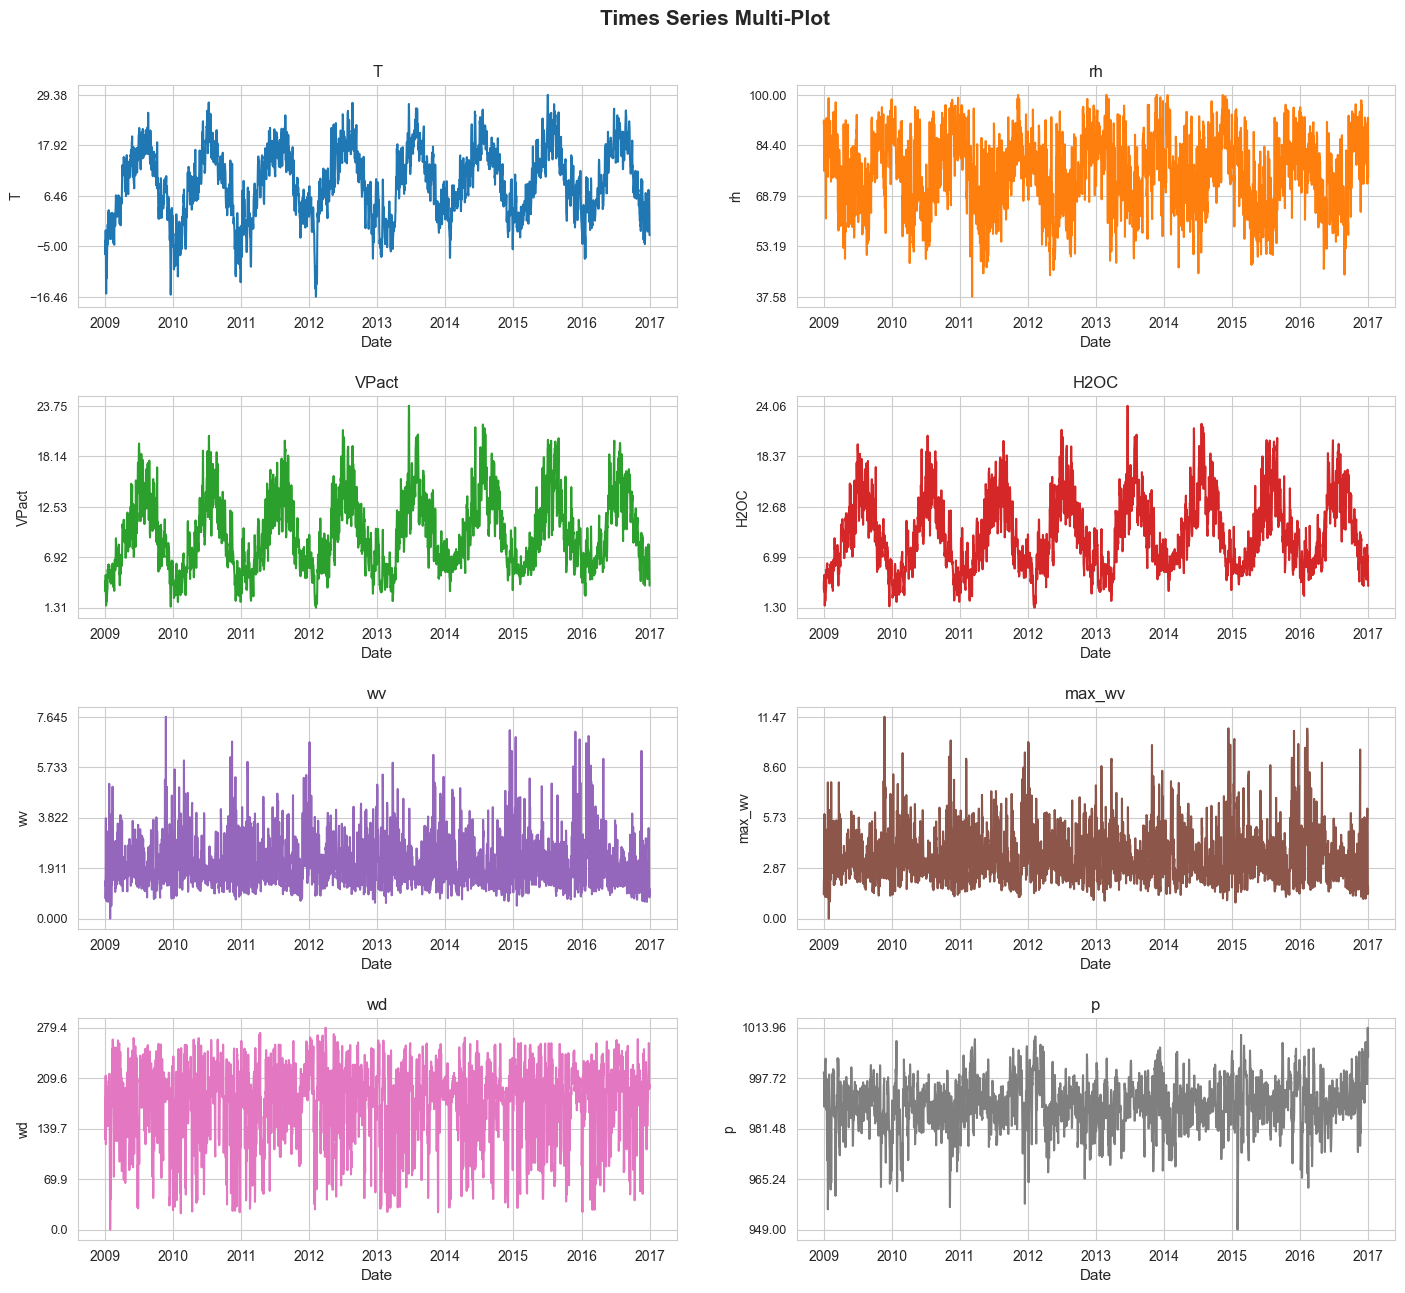

In [17]:
time_series_multi_plot(df=df, n_cols=2, figsize=(17, 15), title='Times Series Multi-Plot', 
                       titles_size=15, title_height=0.93, 
                       subtitles_size=12, hspace=0.4, wspace=0.2)

### **Forecasting workflow**

In this section we are going to use the `PyTS` framework, a personal project that has arose under this master assignment, and, therefore, it still has a lot to improve.

The main goal of this section is to look for the best approach to forecast the temperature in Jena (`T`) 15 days ahead, using tools already provided by `PyTS`.

Since `PyTS` is mainly focus on **univariate** forecasting, this will be the main approach in this section. Later we will use `Skforecast` for both multivariate and multiple forecasting.

#### **Predictors and response definition**

In [18]:
Y, X_st, = {}, {}
X_sk, Y_sk, make_lags = {col: {} for col in variables_forecasting}, {col: {} for col in variables_forecasting}, {col: {} for col in variables_forecasting}
# Defining a grid of lags to be considered as hyper-parameters
lags_grid = [5, 10, 15, 20, 30, 40, 50]

############################################################################
# For univariate forecasting
############################################################################

for col in variables_forecasting:
    # Original series 
    Y[col] = df[col][col].to_numpy()
    # Fake X for statsmodels based implementations
    X_st[col] = np.zeros((len(Y[col]), 4))
                            
    # Lagged X and Y for sklearn based implementations
    for lag in lags_grid:
        make_lags[col][lag] = MakeLags(n_lags=lag, ascending=True)
        make_lags[col][lag].fit()
        X_sk[col][lag], Y_sk[col][lag] = make_lags[col][lag].transform(y=Y[col])

############################################################################
# For multiple forecasting with Statsmodels based implementations
############################################################################

variables_multi = {0: ['T', 'rh', 'wv'], # type 0
                   1: variables_forecasting  # type 1
                   }

Y_pd = {}
for col in variables_forecasting: 
    Y_pd[col] = df[col][col].to_pandas()

X_st_multi = {}
for var_type in variables_multi.keys():
    X_st_multi[var_type] = pd.DataFrame({col: Y_pd[col] for col in variables_multi[var_type]})

We are going to print some of the above objects to see how them look likes and understand them better.

- Full temperature series

In [19]:
Y['T']

array([-6.81062937, -3.72819444, -5.27173611, ...,  2.67625   ,
       -1.70659722, -2.4925    ])

- Fictional predictors matrix for `Statmodels` implementations. 

  It must the same number of rows thatn `Y['T']` and an number of columnas $\geq 2$.

In [20]:
X_st['T']

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

- Temperature series with `5` lags, for Sklearn implementations.

In [21]:
Y_sk['T'][5]

array([-15.48284722, -15.734375  ,  -9.60916667, ...,   2.67625   ,
        -1.70659722,  -2.4925    ])

In [22]:
X_sk['T'][5]

array([[ -4.86715278,  -1.37520833,  -5.27173611,  -3.72819444,
         -6.81062937],
       [-15.48284722,  -4.86715278,  -1.37520833,  -5.27173611,
         -3.72819444],
       [-15.734375  , -15.48284722,  -4.86715278,  -1.37520833,
         -5.27173611],
       ...,
       [  4.88715278,   5.245625  ,   7.52743056,   7.79861111,
          4.53951389],
       [  2.67625   ,   4.88715278,   5.245625  ,   7.52743056,
          7.79861111],
       [ -1.70659722,   2.67625   ,   4.88715278,   5.245625  ,
          7.52743056]])

The following data-frame contains the original temperature and the lagged variables, and allow us to understand better the previous arrays.

Basically, `X_sk['T'][5]` is composed of the lagged variables without the NaN rows, and `Y_sk['T'][5]` the same but with the original series column (the first one).

In [23]:
make_lags['T'][5].y_lags_df.head(7)

Y,Y_lag_1,Y_lag_2,Y_lag_3,Y_lag_4,Y_lag_5
f64,f64,f64,f64,f64,f64
-6.810629,NaN,NaN,NaN,NaN,NaN
-3.728194,-6.810629,NaN,NaN,NaN,NaN
-5.271736,-3.728194,-6.810629,NaN,NaN,NaN
-1.375208,-5.271736,-3.728194,-6.810629,NaN,NaN
-4.867153,-1.375208,-5.271736,-3.728194,-6.810629,NaN
-15.482847,-4.867153,-1.375208,-5.271736,-3.728194,-6.810629
-15.734375,-15.482847,-4.867153,-1.375208,-5.271736,-3.728194


- The predictors matrix for multiple forecasting with  type 0 series `('T', 'rh', 'wv')`, to be used with  `Statmodels` based implementations.

In [24]:
X_st_multi[0]

,T,rh,wv
0,-6.810629,91.086014,0.778601
1,-3.728194,92.086806,1.419514
2,-5.271736,76.458056,1.250903
3,-1.375208,89.417361,1.720417
4,-4.867153,86.260417,3.800278
...,...,...,...
2915,5.245625,72.531806,3.067083
2916,4.887153,84.070833,2.558194
2917,2.676250,90.384722,0.837986
2918,-1.706597,92.927083,1.138125


- The same as before but with type 1 series `('T', 'rh', 'VPact', 'H2OC', 'wv', 'max_wv', 'wd', 'p')`.

In [25]:
X_st_multi[1]

,T,rh,VPact,H2OC,wv,max_wv,wd,p
0,-6.810629,91.086014,3.355524,3.357832,0.778601,1.378252,181.863077,999.145594
1,-3.728194,92.086806,4.267292,4.268750,1.419514,2.227361,125.072014,999.600625
2,-5.271736,76.458056,3.107708,3.111944,1.250903,2.065069,190.383333,998.548611
3,-1.375208,89.417361,4.938958,4.997014,1.720417,3.564861,213.069861,988.510694
4,-4.867153,86.260417,3.806736,3.847778,3.800278,5.940000,118.287361,990.405694
...,...,...,...,...,...,...,...,...
2915,5.245625,72.531806,6.474306,6.428611,3.067083,6.255069,258.195139,1006.777708
2916,4.887153,84.070833,7.269583,7.171875,2.558194,4.726597,254.427708,1013.542986
2917,2.676250,90.384722,6.705833,6.613542,0.837986,1.394028,196.642639,1013.957569
2918,-1.706597,92.927083,5.048542,4.996875,1.138125,1.839306,201.359028,1010.460278


#### **Outer evaluation definition: Time Series Train-Test Split**

For the outer evaluation we are going to use a train-test split.

The train partition will be used in the inner evaluation to select the best alternative, and the test partition in the outer to estimate the best model future performance.

We will use a test window of 15 days, that is the length of the test partition.

In [26]:
# Defining the test_window (in terms of days)
outer_test_window = 15

Now, we define the train-test partitions for both  the statmodels based implementations and for the sklearn ones.

In [27]:
# For Statmodels implementations
X_train_st, X_test_st, Y_train_st, Y_test_st, = {}, {}, {}, {}
X_multi_train_st, X_multi_test_st = {}, {}

# Train-Test split for univariate forecasting with Statsmodels based implementations
for col in variables_forecasting:
    
    X_train_st[col], X_test_st[col], Y_train_st[col], Y_test_st[col] = train_test_split_time_series(X=X_st[col], y=Y[col], test_window=outer_test_window)

# Train-Test split for multiple forecasting with Statsmodels based implementations
for var_type in variables_multi.keys():

    X_multi_train_st[var_type], X_multi_test_st[var_type], _ , _ = train_test_split_time_series(X=X_st_multi[var_type], y=Y['T'], # y is not relevant in this case
                                                                        test_window=outer_test_window,
                                                                        framework='Skforecast')

In [28]:
# For Sklearn implementations
X_train_sk, X_test_sk, Y_train_sk, Y_test_sk = {col: {} for col in variables_forecasting}, {col: {} for col in variables_forecasting}, {col: {} for col in variables_forecasting}, {col: {} for col in variables_forecasting}

# Train-Test split for univariate forecasting with Sklearn based implementations
for col in variables_forecasting:
    for lag in lags_grid:

        X_train_sk[col][lag], X_test_sk[col][lag], Y_train_sk[col][lag], Y_test_sk[col][lag] = train_test_split_time_series(X=X_sk[col][lag], 
                                                                                                                            y=Y_sk[col][lag], 
                                                                                                                            test_window=outer_test_window)

#### **Inner evaluation definition: Times Series Cross Validation**

In the inner evaluation we will use KFold CV for time series, with 10 splits (K) and a test window of 15 days.  

The style of the KFold CV that we are going to apply along this project is illustrated in the following graph:

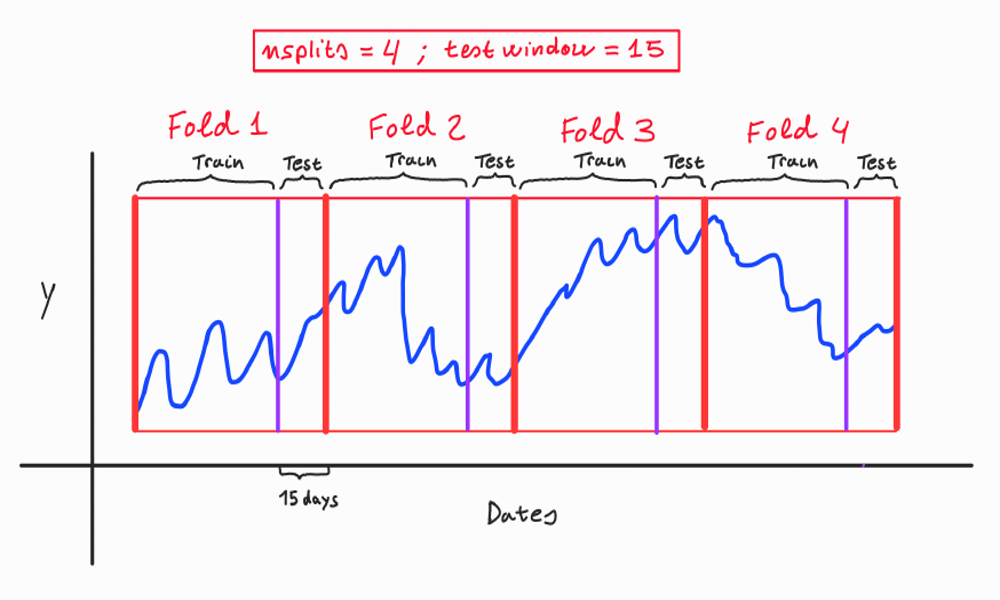

In [30]:
Image.open(r'C:\Users\fscielzo\Documents\DataScience-GitHub\Time Series\Temperature Prediction\Second Project\images\p9.png').resize((1000, 600)).convert("RGB")

We define the  number of splits as 10 and the test window as 15 days.

In [36]:
n_splits = 10 
inner_test_window = 15

#### **Inner evaluation: HPO**

The models that we are going to optimize and test can be classified in two groups, regression models that have been adapted to be use in time series scenarios, and classical time series models. All of them are already available in `PyTS`.

- **Regression  Models**
    - KNN
    - Linear Regression 
    - Trees
    - Extra-trees
    - Bagging with KNN
    - Ridge Regression
    - Lasso Regression
    - ElasticNet Regression
    -  Random Forest
    - Histogram gradient Boosting
    - XGBoost
    - Linear SVM
    - Multi-layer Perceptron (NN)
    - Stacking 

- **Classical Time Series Models**
    - SARIMA
    - Exponential Smoothing
    - VAR

##### **Grids definition**

In this section we are going to define the grids for each one of the above models.


- Grid for KNN

In [ ]:
def param_grid_KNN(trial):

    param_grid = {
        'n_neighbors': trial.suggest_categorical('n_neighbors', [2, 5, 10, 20, 30, 50, 70, 85, 100, 120]), 
        'metric': trial.suggest_categorical('metric', ['minkowski', 'cosine', 'cityblock']),    
        }
    
    # Conditioned grid for KNN
    if param_grid['metric'] == 'minkowski':
        param_grid['p'] = trial.suggest_int('p', 1, 4)
    
    return param_grid

- Grid for Linear Regression

In [ ]:
def param_grid_LinearRegression(trial):

    param_grid = {
        'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),      
        }
    
    return param_grid

- Grid for trees

In [ ]:
# Grid for trees
def param_grid_trees(trial):

    param_grid = {
        'max_depth': trial.suggest_categorical('max_depth', [None, 2, 5, 7, 10, 20, 30]),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 25),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 25),
        'splitter': trial.suggest_categorical('splitter', ['best', 'random']),
        'criterion': trial.suggest_categorical('criterion', ['squared_error', 'absolute_error']),
        #'trees__ccp_alpha': trial.suggest_categorical('trees__ccp_alpha', [0, 0.1, 0.3, 0.5, 0.8])
    }

    return param_grid

- Grid for Extra-trees

In [ ]:
# Grid for extra-trees
def param_grid_extra_trees(trial):

    param_grid = {
        'n_estimators': trial.suggest_categorical('n_estimators', [100, 150, 200, 250]),
        'max_depth': trial.suggest_categorical('max_depth', [10, 20, 30, 40, 55]),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 20),
        'criterion': trial.suggest_categorical('criterion', ['squared_error', 'absolute_error']),
        'max_features': trial.suggest_categorical('max_features', [0.7, 0.8, 0.9, 1.0])
    }

    return param_grid

- Grid for Bagging KNN

In [ ]:
# Grid for bagging knn
def param_grid_bagging_knn(trial):

    # Not conditioned grid for bagging KNN
    param_grid = {
        'n_estimators': trial.suggest_categorical('n_estimators', [10, 20, 30, 50, 70, 100]),
        'max_features': trial.suggest_categorical('max_features', [0.70, 0.80, 0.90, 1.0]),
        'max_samples': trial.suggest_categorical('max_samples', [0.70, 0.80, 0.90, 1.0]),
        'estimator__n_neighbors': trial.suggest_int('estimator__n_neighbors', 1, 25),
        'estimator__metric': trial.suggest_categorical('estimator__metric', ['cosine', 'minkowski', 'cityblock']),
    }

    # Conditioned grid for bagging KNN
    if param_grid['estimator__metric'] == 'minkowski':
        param_grid['estimator__p'] = trial.suggest_int('estimator__p', 1, 4)

    return param_grid

- Grid for Ridge

In [ ]:
# Grid for Ridge
def param_grid_ridge(trial):

    # Specific logic for Ridge
    param_grid = {
        'alpha': trial.suggest_float('alpha', 0.1, 10, log=True)
    }

    return param_grid

- Grid for Lasso

In [ ]:
# Grid for Lasso
def param_grid_lasso(trial):

    # Specific logic for Lasso
    param_grid = {
        'alpha': trial.suggest_float('alpha', 0.1, 10, log=True)
    }

    return param_grid

- Grid for ElasticNet

In [ ]:
# Grid for ElasticNet
def param_grid_elastic_net(trial):

    # Specific logic for Lasso
    param_grid = {
        'alpha': trial.suggest_float('alpha', 0.1, 10, log=True),
        'l1_ratio': trial.suggest_float('l1_ratio', 0.1, 0.9, step=0.02)
    }

    return param_grid

- Grid for Random Forest

In [ ]:
# Grid for Random Forest
def param_grid_RF(trial):

    # Specific logic for Lasso
    param_grid = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 120),
        'max_depth': trial.suggest_int('max_depth', 2, 15),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 25),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 25)
    }

    return param_grid

- Grid for Histogram Gradient Boosting

In [ ]:
# Grid for Histogram Gradient Boosting 
def param_grid_HGB(trial):

    # Specific logic for HGB
    param_grid = {
        'max_depth': trial.suggest_categorical('max_depth', [10, 20, 30, 40, 50]),
        'l2_regularization': trial.suggest_float('l2_regularization', 0.01, 0.7, log=True),
        'max_iter': trial.suggest_categorical('max_iter', [70, 100, 130, 150, 170, 200])
    }

    return param_grid

- Grid for XGBoost

In [ ]:
# Grid for XGBoost
def param_grid_XGB(trial):

    # Specific logic for XGBoost
    param_grid = {
        'max_depth': trial.suggest_categorical('max_depth', [10, 20, 30, 40, 50]),
        'l2_regularization': trial.suggest_float('l2_regularization', 0, 0.5, step=0.1, log=False),
        'n_estimators': trial.suggest_categorical('n_estimators', [70, 100, 150, 180]),
        'eta': trial.suggest_float('eta', 0, 0.3, step=0.02, log=False),
        'alpha': trial.suggest_float('alpha', 0.2, 1, step=0.01, log=False)
    }

    return param_grid

- Grid for Linear SVM

In [ ]:
# Grid for Linear SVM
def param_grid_linear_SVM(trial):

    # Specific logic for Linear SVM
    param_grid = {
        'epsilon': trial.suggest_categorical('epsilon', [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 1.5]),
        'C': trial.suggest_categorical('C', [0.1, 0.7, 1, 5, 10, 20, 50, 100])
    }

    return param_grid

- Grid for MLP

In [ ]:
# Grid for Multi-Layer Perceptron
def param_grid_MLP_NN(trial):

    # Specific logic for NN
    param_grid = {
        'learning_rate_init': trial.suggest_float('learning_rate_init', 0.001, 2, log=True),
        'alpha': trial.suggest_float('alpha', 0.01, 1, log=True)
    }

    return param_grid

- Grid for SARIMA

In [ ]:
# Grid for SARIMA
def param_grid_SARIMA(trial):

    param_grid = {
        'p': trial.suggest_categorical('p', [0, 1, 2, 3]),
        'd': trial.suggest_categorical('d', [0, 1, 2]),
        'q': trial.suggest_categorical('q', [0, 1, 2]),
        'P': trial.suggest_categorical('P', [0, 1, 2]),
        'D': trial.suggest_categorical('D', [0, 1, 2]),
        'Q': trial.suggest_categorical('Q', [0, 1, 2]),
        's': trial.suggest_categorical('s', [5, 7]),
    }

    return param_grid

- Grid for Exponential Smoothing

In [ ]:
# Grid for Exp.Smoothing
def param_grid_ExpSmooth(trial):

    param_grid = {
        'smoothing_level': trial.suggest_float('smoothing_level', 0.01, 5, log=True)
    }

    return param_grid

- Grid for Stacking with Random Forest

In [ ]:
# Grid for Stacking with RF
def param_grid_stacking_RF(trial):

    param_grid = {
        'final_estimator__n_estimators': trial.suggest_int('final_estimator__n_estimators', 50, 120),
        'final_estimator__max_depth': trial.suggest_int('final_estimator__max_depth', 2, 15),
        'final_estimator__min_samples_split': trial.suggest_int('final_estimator__min_samples_split', 2, 25),
        'final_estimator__min_samples_leaf': trial.suggest_int('final_estimator__min_samples_leaf', 2, 25)
    }

    return param_grid

- Grid for VAR

In [ ]:
# Grid for VAR
def param_grid_VAR(trial):

    param_grid = {
        'maxlags': trial.suggest_categorical('maxlags', [1, 3, 5, 7, 10, 15, 20]),
        'ic': trial.suggest_categorical('ic', ['aic', 'bic', 'fpe', 'hqic'])
    }

    return param_grid

##### **Applying HPO**

In this section we are going to apply HPO on the above models.

For now, we will explore mainly **univariate** approach to forecast the **temperature** in Jena `(T)`. 


- For the regression models defined above: **univariate** and **multivariate**.

- For SARIMA and Exponential Smoothing: **univariate**.

- For VAR: **multiple**. 

For all the cases a recursive forecasting strategy will be used (the only one available in `PyTS`currently).



We are going to find the best hyper-parameter combination for each alternative.

**Important:** in the multivariate  approach with VAR we will explore two sets of variables, type 0   `('T', 'rh', 'wv')` and type 1 `('T', 'rh', 'VPact', 'H2OC', 'wv', 'max_wv', 'wd', 'p')`. 

Another important thing to clarify is that we are going to use a percentage error metric to measure how well or bad the model is performing in porcentual terms. 

The most common metric for this purpose is the MAPE (Mean Absolute Percentage Error) but it has a big problem, since enlarge the error artificially for close to zero true/predicted values, and for zero real values is directly non define.

A metric with the seam spirit (measure the prediction error in percentage) but without this problem is the WAPE (Weighted Absolute Percentage Error), which is the MAE (Mean Absolute Error) divided by the mean of the absolute true values. 

WAPE is a metric that contextualize the MAE by dividing it by the mean of the absolute true values of the response.

In the following page you can find a toy example that explains this perfectly: https://www.baeldung.com/cs/mape-vs-wape-vs-wmape



In [31]:
series_name = 'T' # The name of the series for which we are looking for the best model.

In [ ]:
best_score, best_params, inner_results = {}, {}, {}

- **KNN univariate** forecasting approach

In [ ]:
estimator = KNeighborsRegressorTS()
param_grid = param_grid_KNN
n_iter = 70

for lag in lags_grid:

    optuna_search = OptunaSearchTSCV(estimator=estimator, param_grid=param_grid, 
                                     n_splits=n_splits, test_window=inner_test_window,
                                     n_lags=lag, scoring=wape, direction='minimize', 
                                     n_iter=n_iter, random_state=123, kfold_verbose=False,
                                     framework='PyTS')

    optuna_search.fit(X=X_train_sk[series_name][lag], y=Y_train_sk[series_name][lag])

    name = f'KNN(lag={lag})'
    best_params[name] = optuna_search.best_params_
    best_score[name] = optuna_search.best_score_
    inner_results[name] = optuna_search.results()


- **Linear Regression univariate** forecasting approach

In [ ]:
estimator = LinearRegressionTS()
param_grid = param_grid_LinearRegression
n_iter = 2

for lag in lags_grid:

    optuna_search = OptunaSearchTSCV(estimator=estimator, param_grid=param_grid, 
                                     n_splits=n_splits, test_window=inner_test_window,
                                     n_lags=lag, scoring=wape, direction='minimize', 
                                     n_iter=n_iter, random_state=123, kfold_verbose=False,
                                     framework='PyTS')

    optuna_search.fit(X=X_train_sk[series_name][lag], y=Y_train_sk[series_name][lag])

    name = f'Linear_Regression(lag={lag})'
    best_params[name] = optuna_search.best_params_
    best_score[name] = optuna_search.best_score_
    inner_results[name] = optuna_search.results()


- **Trees univariate** forecasting approach

In [ ]:
estimator = DecisionTreeRegressorTS()
param_grid = param_grid_trees
n_iter = 65

for lag in lags_grid:

    optuna_search = OptunaSearchTSCV(estimator=estimator, param_grid=param_grid, 
                                     n_splits=n_splits, test_window=inner_test_window,
                                     n_lags=lag, scoring=wape, direction='minimize', 
                                     n_iter=n_iter, random_state=123, kfold_verbose=False,
                                     framework='PyTS')

    optuna_search.fit(X=X_train_sk[series_name][lag], y=Y_train_sk[series_name][lag])

    name = f'Trees(lag={lag})'
    best_params[name] = optuna_search.best_params_
    best_score[name] = optuna_search.best_score_
    inner_results[name] = optuna_search.results()


- **Ridge univariate** forecasting approach

In [ ]:
estimator = RidgeTS()
param_grid = param_grid_ridge
n_iter = 65

for lag in lags_grid:

    optuna_search = OptunaSearchTSCV(estimator=estimator, param_grid=param_grid, 
                                     n_splits=n_splits, test_window=inner_test_window,
                                     n_lags=lag, scoring=wape, direction='minimize', 
                                     n_iter=n_iter, random_state=123, kfold_verbose=False,
                                     framework='PyTS')

    optuna_search.fit(X=X_train_sk[series_name][lag], y=Y_train_sk[series_name][lag])

    name = f'Ridge(lag={lag})'
    best_params[name] = optuna_search.best_params_
    best_score[name] = optuna_search.best_score_
    inner_results[name] = optuna_search.results()


- **Lasso univariate** forecasting approach

In [ ]:
estimator = LassoTS()
param_grid = param_grid_lasso
n_iter = 65

for lag in lags_grid:

    optuna_search = OptunaSearchTSCV(estimator=estimator, param_grid=param_grid, 
                                     n_splits=n_splits, test_window=inner_test_window,
                                     n_lags=lag, scoring=wape, direction='minimize', 
                                     n_iter=n_iter, random_state=123, kfold_verbose=False,
                                     framework='PyTS')

    optuna_search.fit(X=X_train_sk[series_name][lag], y=Y_train_sk[series_name][lag])

    name = f'Lasso(lag={lag})'
    best_params[name] = optuna_search.best_params_
    best_score[name] = optuna_search.best_score_
    inner_results[name] = optuna_search.results()


- **ElasticNet univariate** forecasting approach

In [ ]:
estimator = ElasticNetTS()
param_grid = param_grid_elastic_net
n_iter = 65

for lag in lags_grid:

    optuna_search = OptunaSearchTSCV(estimator=estimator, param_grid=param_grid, 
                                     n_splits=n_splits, test_window=inner_test_window,
                                     n_lags=lag, scoring=wape, direction='minimize',  
                                     n_iter=n_iter, random_state=123, kfold_verbose=False,
                                     framework='PyTS')

    optuna_search.fit(X=X_train_sk[series_name][lag], y=Y_train_sk[series_name][lag])

    name = f'ElasticNet(lag={lag})'
    best_params[name] = optuna_search.best_params_
    best_score[name] = optuna_search.best_score_
    inner_results[name] = optuna_search.results()


- **Random Forest** univariate forecasting approach

In [ ]:
estimator = RandomForestRegressorTS(random_state=123)
param_grid = param_grid_RF
n_iter = 70

for lag in lags_grid:

    optuna_search = OptunaSearchTSCV(estimator=estimator, param_grid=param_grid, 
                                     n_splits=n_splits, test_window=inner_test_window,
                                     n_lags=lag, scoring=wape, direction='minimize',  
                                     n_iter=n_iter, random_state=123, kfold_verbose=False,
                                     framework='PyTS')

    optuna_search.fit(X=X_train_sk[series_name][lag], y=Y_train_sk[series_name][lag])

    name = f'RF(lag={lag})'
    best_params[name] = optuna_search.best_params_
    best_score[name] = optuna_search.best_score_
    inner_results[name] = optuna_search.results()


- **XGBoost univariate** forecasting approach

In [ ]:
estimator = XGBRegressorTS(random_state=123)
param_grid = param_grid_XGB
n_iter = 100

for lag in lags_grid:

    optuna_search = OptunaSearchTSCV(estimator=estimator, param_grid=param_grid, 
                                     n_splits=n_splits, test_window=inner_test_window,
                                     n_lags=lag, scoring=wape, direction='minimize', 
                                     n_iter=n_iter, random_state=123, kfold_verbose=False,
                                     framework='PyTS')

    optuna_search.fit(X=X_train_sk[series_name][lag], y=Y_train_sk[series_name][lag])

    name = f'XGB(lag={lag})'
    best_params[name] = optuna_search.best_params_
    best_score[name] = optuna_search.best_score_
    inner_results[name] = optuna_search.results()


- **Histogram gradient boosting univariate** forecasting approach


In [ ]:
estimator = HistGradientBoostingRegressorTS(random_state=123)
param_grid = param_grid_HGB
n_iter = 70

for lag in lags_grid:

    optuna_search = OptunaSearchTSCV(estimator=estimator, param_grid=param_grid, 
                                     n_splits=n_splits, test_window=inner_test_window,
                                     n_lags=lag, scoring=wape, direction='minimize', 
                                     n_iter=n_iter, random_state=123, kfold_verbose=False,
                                     framework='PyTS')

    optuna_search.fit(X=X_train_sk[series_name][lag], y=Y_train_sk[series_name][lag])

    name = f'HGB(lag={lag})'
    best_params[name] = optuna_search.best_params_
    best_score[name] = optuna_search.best_score_
    inner_results[name] = optuna_search.results()


- **Linear SVM univariate** forecasting approach

In [ ]:
estimator = LinearSVRTS()
param_grid = param_grid_linear_SVM
n_iter = 70

for lag in lags_grid:

    optuna_search = OptunaSearchTSCV(estimator=estimator, param_grid=param_grid, 
                                     n_splits=n_splits, test_window=inner_test_window,
                                     n_lags=lag, scoring=wape, direction='minimize', 
                                     n_iter=n_iter, random_state=123, kfold_verbose=False,
                                     framework='PyTS')

    optuna_search.fit(X=X_train_sk[series_name][lag], y=Y_train_sk[series_name][lag])

    name = f'SVM(lag={lag})'
    best_params[name] = optuna_search.best_params_
    best_score[name] = optuna_search.best_score_
    inner_results[name] = optuna_search.results()


- **MLP NN univariate** forecasting approach

In [ ]:
estimator = MLPRegressorTS(random_state=123)
param_grid = param_grid_MLP_NN
n_iter = 70

for lag in lags_grid:

    optuna_search = OptunaSearchTSCV(estimator=estimator, param_grid=param_grid, 
                                     n_splits=n_splits, test_window=inner_test_window,
                                     n_lags=lag, scoring=wape, direction='minimize', 
                                     n_iter=n_iter, random_state=123, kfold_verbose=False,
                                     framework='PyTS')

    optuna_search.fit(X=X_train_sk[series_name][lag], y=Y_train_sk[series_name][lag])

    name = f'MLP(lag={lag})'
    best_params[name] = optuna_search.best_params_
    best_score[name] = optuna_search.best_score_
    inner_results[name] = optuna_search.results()


- **SARIMA univariate** forecasting approach

In [ ]:
estimator = SARIMA()
param_grid = param_grid_SARIMA
n_iter = 65

optuna_search = OptunaSearchTSCV(estimator=estimator, param_grid=param_grid, 
                                     n_splits=n_splits, test_window=inner_test_window,
                                     scoring=wape, direction='minimize', 
                                     n_iter=n_iter, random_state=111, kfold_verbose=False,
                                     framework='PyTS')

optuna_search.fit(X=X_train_st[series_name], y=Y_train_st[series_name])

name = 'SARIMA'
best_params[name] = optuna_search.best_params_
best_score[name] = optuna_search.best_score_
inner_results[name] = optuna_search.results()


- **Simple Exponential Smoothing univariate** forecasting approach

In [ ]:
estimator = SimpleExpSmooth()
param_grid = param_grid_ExpSmooth
n_iter = 300

optuna_search = OptunaSearchTSCV(estimator=estimator, param_grid=param_grid, 
                                     n_splits=n_splits, test_window=inner_test_window,
                                     scoring=wape, direction='minimize', 
                                     n_iter=n_iter, random_state=123, kfold_verbose=False,
                                     framework='PyTS')

optuna_search.fit(X=X_train_st[series_name], y=Y_train_st[series_name])

name = 'ExpSmooth'
best_params[name] = optuna_search.best_params_
best_score[name] = optuna_search.best_score_
inner_results[name] = optuna_search.results()


- **Extra-trees univariate** forecasting approach

In [ ]:
# This model destroys the time series structure
'''
estimator = ExtraTreesRegressorTS()
param_grid = param_grid_extra_trees
n_iter = 50

for lag in lags_grid:

    optuna_search = OptunaSearchTSCV(estimator=estimator, param_grid=param_grid, 
                                     n_splits=n_splits, test_window=inner_test_window,
                                     scoring=mean_absolute_error, direction='minimize', 
                                     n_iter=n_iter, random_state=123, kfold_verbose=False)

    optuna_search.fit(X=X_train_sk[series_name][lag], y=Y_train_sk[series_name][lag])

    name = f'Trees(lag={lag})'
    best_params[name] = optuna_search.best_params_
    best_score[name] = optuna_search.best_score_
    inner_results[name] = optuna_search.results()
'''

- **Bagging KNN univariate** forecasting approach

In [ ]:
# This model destroys the time series structure
'''
estimator = BaggingRegressorTS(estimator=KNeighborsRegressorTS())
param_grid = param_grid_bagging_knn
n_iter = 50

for lag in lags_grid:

    optuna_search = OptunaSearchTSCV(estimator=estimator, param_grid=param_grid, 
                                     n_splits=n_splits, test_window=inner_test_window,
                                     scoring=mean_absolute_error, direction='minimize', 
                                     n_iter=n_iter, random_state=123, kfold_verbose=False)

    optuna_search.fit(X=X_train_sk[series_name][lag], y=Y_train_sk[series_name][lag])

    name = f'Extra_Trees(lag={lag})'
    best_params[name] = optuna_search.best_params_
    best_score[name] = optuna_search.best_score_
    inner_results[name] = optuna_search.results()
'''

- **Stacking RF univariate** forecasting approach

In [ ]:
base_models = [
    ('SVM', LinearSVRTS().set_params(**best_params['SVM(lag=30)'])),
    ('ElasticNet', ElasticNetTS().set_params(**best_params['ElasticNet(lag=40)']))
]

stacking_SVM_Elastic_RF = StackingRegressorTS(estimators=base_models, 
                                              final_estimator=RandomForestRegressorTS(random_state=123).set_params(**best_params['RF(lag=30)']), 
                                              cv=5)

In [ ]:
estimator = stacking_SVM_Elastic_RF
param_grid = param_grid_stacking_RF
n_iter = 60

for lag in [20, 30, 40, 50]:

    optuna_search = OptunaSearchTSCV(estimator=estimator, param_grid=param_grid, 
                                     n_splits=n_splits, test_window=inner_test_window,
                                     n_lags=lag, scoring=wape, direction='minimize', 
                                     n_iter=n_iter, random_state=111, kfold_verbose=False,
                                     framework='PyTS')

    optuna_search.fit(X=X_train_sk[series_name][lag], y=Y_train_sk[series_name][lag])

    name = f'stacking_SVM_Elastic_RF(lag={lag})'
    best_params[name] = optuna_search.best_params_
    best_score[name] = optuna_search.best_score_
    inner_results[name] = optuna_search.results()


- **VAR multivariate**  forecasting approach

In [ ]:
estimator = VAR(maxlags=10, ic='aic')                                  
param_grid = param_grid_VAR
n_iter = 75

for var_type in variables_multi.keys():
 
    optuna_search = OptunaSearchTSCV(estimator=estimator, param_grid=param_grid, 
                                        n_splits=n_splits, test_window=inner_test_window,
                                        level=series_name, scoring=wape, direction='minimize', 
                                        n_iter=n_iter, random_state=123, kfold_verbose=False,
                                        framework='PyTS', approach='multivariate'
                                        )

    optuna_search.fit(X=X_multi_train_st[var_type], y=Y_train_st[series_name])

    model_name = f'VAR(variables_type={var_type})'
    best_params[model_name] = optuna_search.best_params_
    best_score[model_name] = optuna_search.best_score_
    inner_results[model_name] = optuna_search.results()


**Saving the results:**

In [ ]:
# Saving the results as pickle files

'''
with open(f'results/inner_results', 'wb') as file:
    pickle.dump(inner_results, file)

with open(f'results/best_params', 'wb') as file:
    pickle.dump(best_params, file)

with open(f'results/best_score', 'wb') as file:
    pickle.dump(best_score, file)
'''

**Opening the results:**

In [33]:
with open(r'C:\Users\fscielzo\Documents\DataScience-GitHub\Time Series\Temperature Prediction\Second Project\results\inner_results', 'rb') as file:
        inner_results = pickle.load(file)

with open(r'C:\Users\fscielzo\Documents\DataScience-GitHub\Time Series\Temperature Prediction\Second Project\results\best_params', 'rb') as file:
        best_params = pickle.load(file)

with open(r'C:\Users\fscielzo\Documents\DataScience-GitHub\Time Series\Temperature Prediction\Second Project\results\best_score', 'rb') as file:
        best_score = pickle.load(file)

#### **Inner evaluation: selecting the best model**

In this section we are going to plot the obtained results regarding the inner score of the tried models and select the best one, that is, the one with less inner WAPE.

In [34]:
model_names = np.array(list(best_score.keys()))
inner_scores_values = np.array(list(best_score.values()))
best_model = model_names[np.argmin(inner_scores_values)]
score_best_model = np.min(inner_scores_values)

combined_models_score = list(zip(model_names, inner_scores_values))
sorted_combined_models_score= sorted(combined_models_score, key=lambda x: x[1], reverse=False)  # Sort from lower to greater
sorted_models, sorted_scores = zip(*sorted_combined_models_score)
sorted_models, sorted_scores = list(sorted_models), list(sorted_scores)

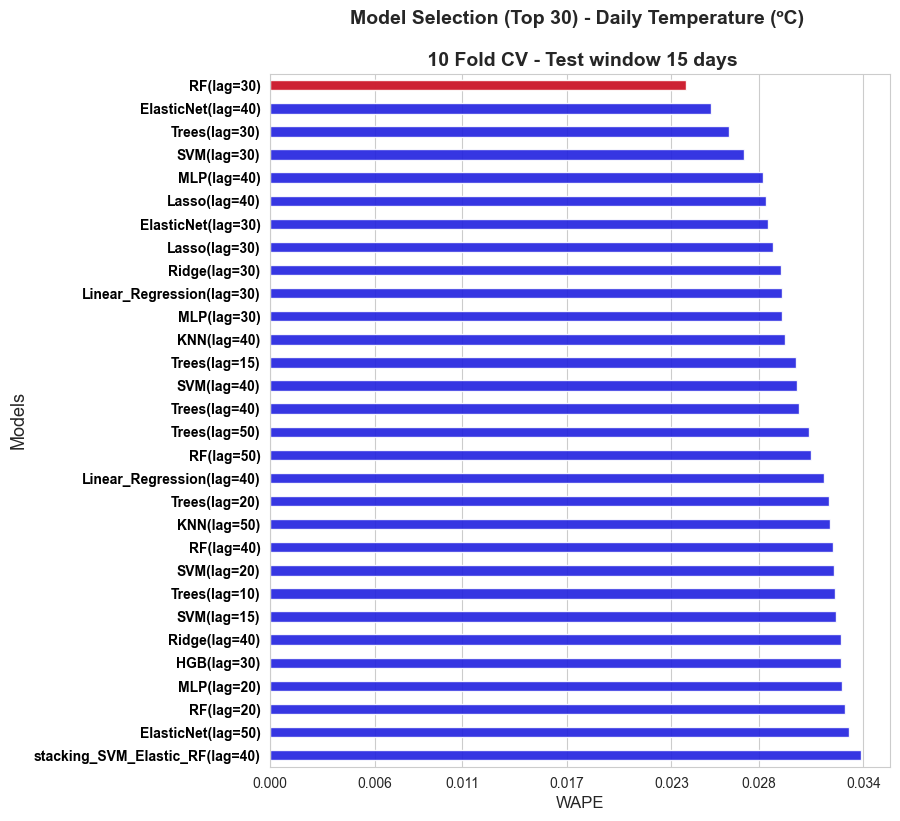

In [37]:
top = 30 

fig, axes = plt.subplots(figsize=(8,9))

ax = sns.barplot(y=sorted_models[0:top], x=sorted_scores[0:top], color='blue', width=0.45, alpha=0.9)
ax = sns.barplot(y=[best_model], x=[score_best_model], color='red', width=0.45, alpha=0.9)

ax.set_ylabel('Models', size=13)
ax.set_xlabel('WAPE', size=12)
ax.set_xticks(np.round(np.linspace(0, np.max(sorted_scores[0:top]), 7),3)) 
ax.tick_params(axis='y', labelsize=10)    
plt.title(f'Model Selection (Top {top}) - Daily Temperature (ºC) \n\n {n_splits} Fold CV - Test window {inner_test_window} days', size=14, weight='bold')

for label in ax.get_yticklabels():
        label.set_weight('bold')
        label.set_color('black') 

plt.show()

The best model is Random Forest with 30 lags and the following hyper-parameters:

In [38]:
best_params[best_model]

{'n_estimators': 84,
 'max_depth': 7,
 'min_samples_split': 10,
 'min_samples_leaf': 19}

The complete dictionary of models-score is the following:

In [39]:
best_score

{'KNN(lag=5)': 0.04475634362175205,
 'Trees(lag=5)': 0.041772805314552366,
 'Trees(lag=10)': 0.03239807314611764,
 'Trees(lag=15)': 0.03013822250631294,
 'Trees(lag=20)': 0.03205089375175597,
 'Trees(lag=30)': 0.026302549971964052,
 'Trees(lag=40)': 0.030310388010695067,
 'Trees(lag=50)': 0.030875561177378642,
 'Ridge(lag=5)': 0.04695397858114005,
 'Ridge(lag=10)': 0.04500056146125388,
 'Ridge(lag=15)': 0.03850592364222643,
 'Ridge(lag=20)': 0.03922720311833498,
 'Ridge(lag=30)': 0.029263168699687803,
 'Ridge(lag=40)': 0.032712958130443226,
 'Ridge(lag=50)': 0.039082535149148584,
 'Lasso(lag=5)': 0.047527893650982464,
 'Lasso(lag=10)': 0.044711227366435534,
 'Lasso(lag=15)': 0.03872078481015994,
 'Lasso(lag=20)': 0.038273268527007936,
 'Lasso(lag=30)': 0.02883878311828363,
 'Lasso(lag=40)': 0.028417315855563265,
 'Lasso(lag=50)': 0.03490035743239682,
 'ElasticNet(lag=5)': 0.04677197645336836,
 'ElasticNet(lag=10)': 0.04394329525969322,
 'ElasticNet(lag=15)': 0.038209590844635107,
 'Ela

##### **Visualization of inner evaluation**

In this section we are going to visualize how the inner score has been compute (using the best model as example). This is also useful for understanding how KFold CV works in Time Series, and why it is preferable over other alternatives las hold-out (train-test split) or another time series validation styles.

The following multi-plot has 10 subplots, one per fold, and in each one the true series can be seen in blue and the model prediction for the test window (15 days) in red. 

In each fold the model is train with the train window (the period before the test prediction), and after that is used to predict the test window. 

We also have information regarding the obtained score in each fold. The final score with this approach is the mean of those 10 scores.

Fold's size: 287. Train size: 272. Test size: 15


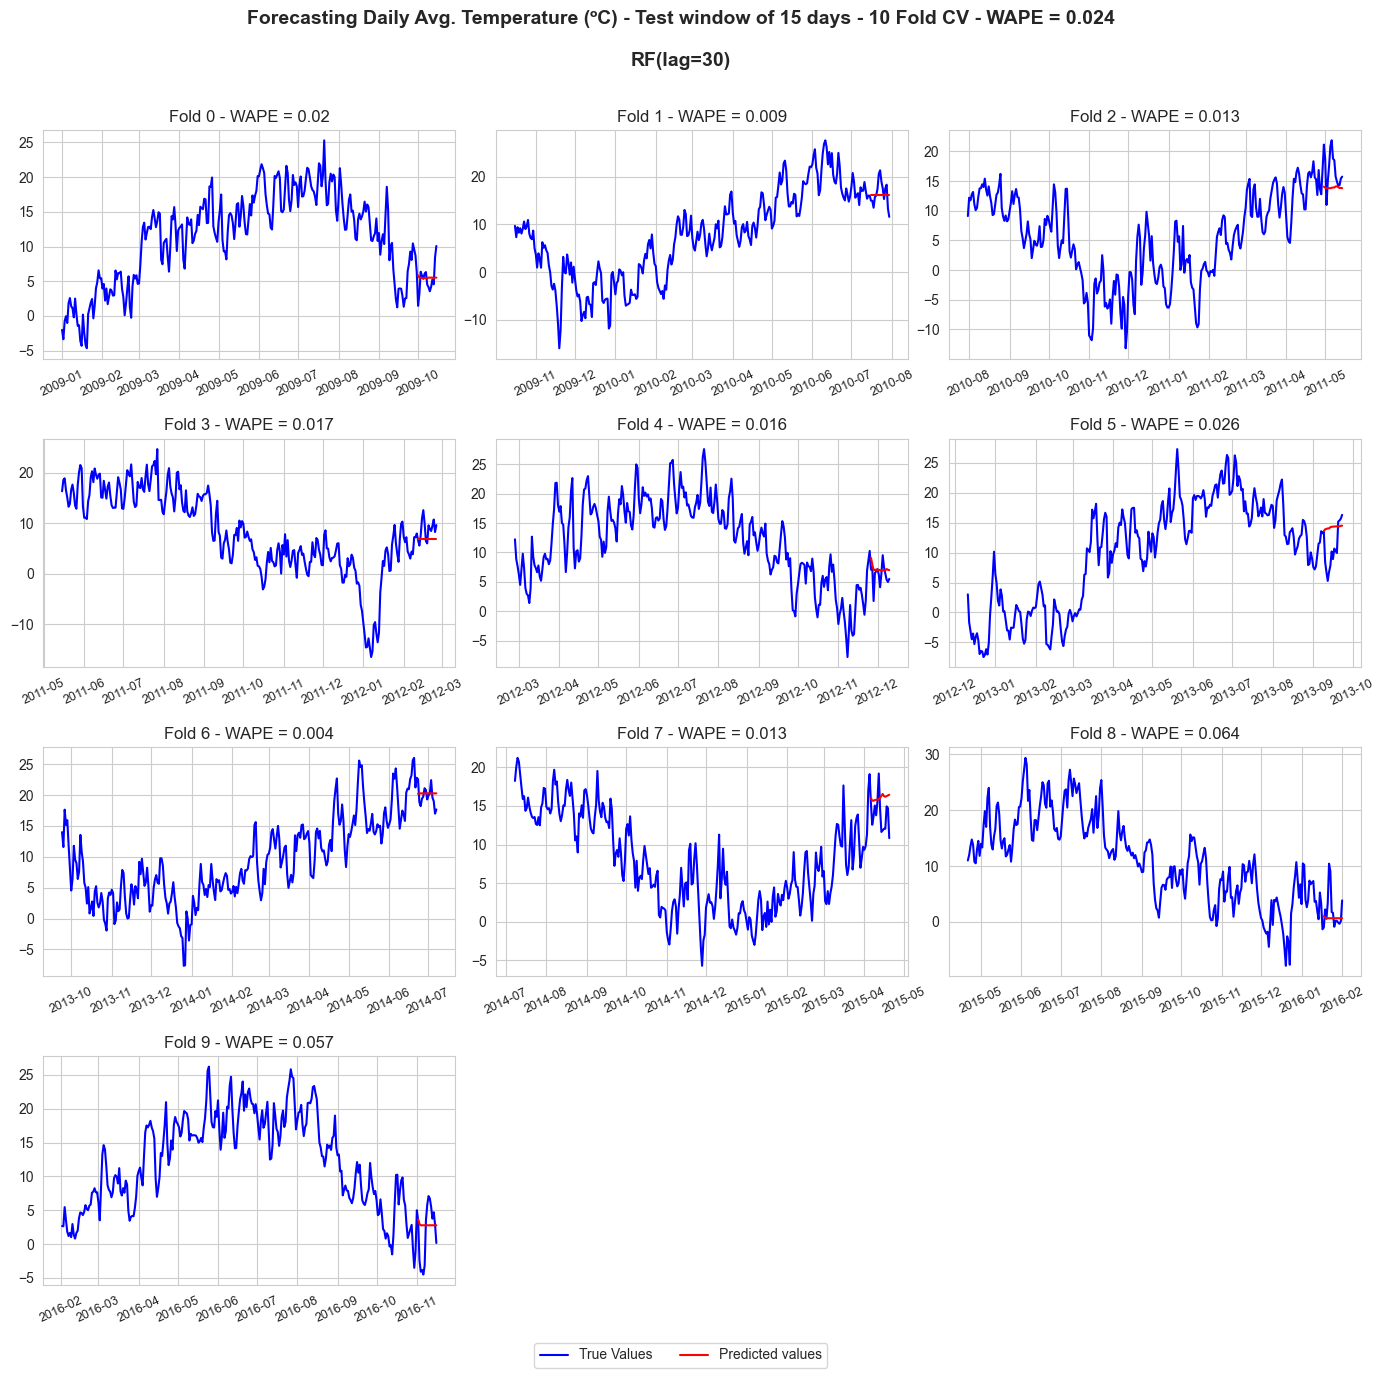

In [40]:
dates = df['T']['date'].to_numpy()
best_estimator = RandomForestRegressorTS(random_state=123).set_params(**best_params[best_model])
lag = 30
model_name = f'RF(lag={lag})'
series_name = 'T'

KFold_time_series_plot(n_cols=3, figsize=(17,15), estimator=best_estimator,  score=wape, n_lags=lag,
                       X=X_train_sk[series_name][lag], y=Y_train_sk[series_name][lag], n_splits=n_splits, test_window=inner_test_window, dates=dates,
                       true_color='blue', pred_color='red', marker='', markersize=4,
                       title=f"Forecasting Daily Avg. Temperature (ºC) - Test window of {inner_test_window} days - {n_splits} Fold CV - WAPE = {np.round(best_score[model_name],3)}\n\n{model_name}",
                       hspace=0.35, wspace=0.1, subtitles_size=12, title_size=14, xticks_rotation=25, 
                       bbox_to_anchor=(0.5,0.05), score_name='WAPE')

#### **Outer evaluation: estimation of future performance**

Estimation of future performance of the best model, that is, the performance of the best model of this section predicting the test set.

In [41]:
lag = 30
best_estimator.fit(X=X_train_sk[series_name][lag], y=Y_train_sk[series_name][lag])
Y_test_hat = best_estimator.forecast(window=outer_test_window, n_lags=lag)
future_performance = wape(y_pred=Y_test_hat, y_true=Y_test_sk[series_name][lag])
future_performance

0.059978571407479475

In [42]:
lag = 30
best_estimator.fit(X=X_train_sk[series_name][lag], y=Y_train_sk[series_name][lag])
Y_test_hat = best_estimator.forecast(window=outer_test_window, n_lags=lag)
future_performance_MAE = mean_absolute_error(y_pred=Y_test_hat, y_true=Y_test_sk[series_name][lag])
future_performance_MAE

2.81607723115256

#### **Outer evaluation: visualization**


In this section we display a plot to visualize how the best model performs in the testing set.

In the plot we can see the last part of the original series along with the predictions of the best model for the test partition (outer test window of 15 days) as well as for the upcoming 15 days (forecasting window).

In [43]:
forecast_window = 15

In [46]:
# Resources to plot test and future forecast

best_estimator.fit(X=X_train_sk[series_name][lag], y=Y_train_sk[series_name][lag])
Y_test_hat = best_estimator.forecast(window=inner_test_window, n_lags=lag)

best_estimator.fit(X=X_sk[series_name][lag], y=Y_sk[series_name][lag])
Y_future_hat = best_estimator.forecast(window=forecast_window, n_lags=lag)

Y_hat = {}
Y_hat[best_model] = np.concatenate((Y_test_hat, Y_future_hat))
predicted_values = Y_hat

dates = df['T']['date'].to_numpy()
prediction_dates = get_prediction_dates(dates, inner_test_window, forecast_window)

future_performance = {best_model: future_performance}

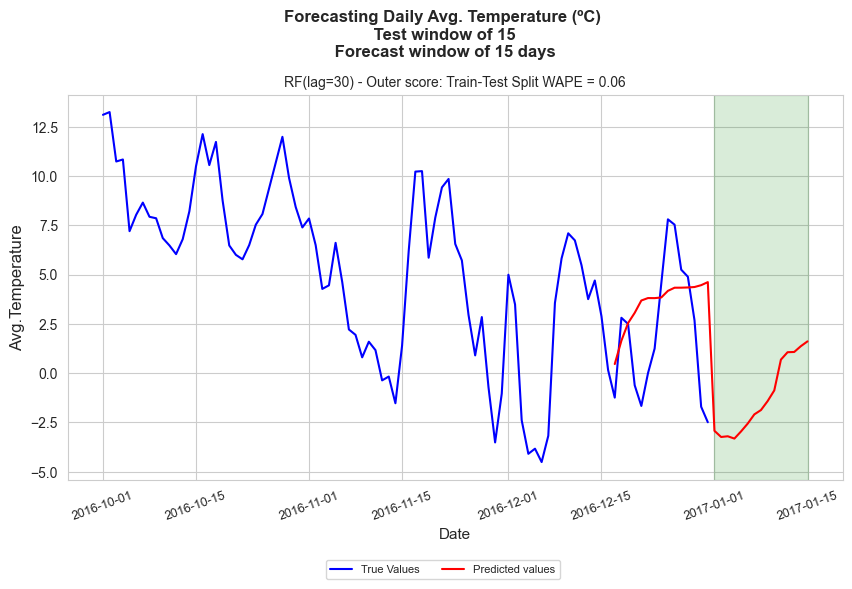

In [49]:
# Plotting test and future forecast
predictive_time_series_plot(n_cols=1, figsize=(10,5), 
                            data=df['T'].filter(pl.col('year')==2016, pl.col('month').is_in([10, 11, 12])), 
                            x_name='date', y_name='T', true_color='blue', pred_color='red',
                            predicted_values=predicted_values, prediction_dates=prediction_dates, test_window=inner_test_window, 
                            scores=future_performance, score_name='Outer score: Train-Test Split WAPE',
                            title=f"Forecasting Daily Avg. Temperature (ºC)\n\n Test window = {outer_test_window} - Forecast window = {forecast_window} days",  
                            title_size=12, title_weight='bold', subtitles_size=10,
                            marker='', markersize=5, ylabel='Avg.Temperature', xlabel='Date',
                            xticks_size=9, hspace=0.7, wspace=0.13, xticks_rotation=20, xlabel_size=11, ylabel_size=11,
                            title_height=1.05, shadow_alpha=0.15, shadow_color='green', legend_size=8, bbox_to_anchor=(0.5,-0.1))


#### **Predictive visualization of the top models**

Here we reproduce the previous plot but for the top-10 models and showing their inner scores as well, since were the ones used to sort them in terms of forecasting error.

In [50]:
Y_hat = {}
top = 10
model_names = sorted_models[0:top]

models_dict =  {'RF': RandomForestRegressorTS(random_state=123),
                'SVM': LinearSVRTS(),
                'ElasticNet': ElasticNetTS(),
                'Trees': DecisionTreeRegressorTS(),
                'Lasso': LassoTS(),
                'Ridge': RidgeTS(),
                'Linear_Regression': LinearRegressionTS(),
                'MLP': MLPRegressorTS(random_state=123)
               }


estimators = {model_name: models_dict[re.match(r'^([^(]+)', model_name).group(1)] for model_name in model_names}

lags = {model_name: int(re.search(r'lag=(\d+)', model_name).group(1)) for model_name in model_names}

In [51]:
for name in model_names: 
    print(name)

    estimator = estimators[name].set_params(**best_params[name])
    estimator.fit(X=X_train_sk[series_name][lags[name]], y=Y_train_sk[series_name][lags[name]])        
    Y_test_hat = estimator.forecast(window=inner_test_window, n_lags=lags[name])
    estimator.fit(X=X_sk[series_name][lags[name]], y=Y_sk[series_name][lags[name]])
    Y_future_hat = estimator.forecast(window=forecast_window, n_lags=lags[name])

    Y_hat[name] = np.concatenate((Y_test_hat, Y_future_hat))

RF(lag=30)
ElasticNet(lag=40)
Trees(lag=30)
SVM(lag=30)
MLP(lag=40)
Lasso(lag=40)
ElasticNet(lag=30)
Lasso(lag=30)
Ridge(lag=30)
Linear_Regression(lag=30)


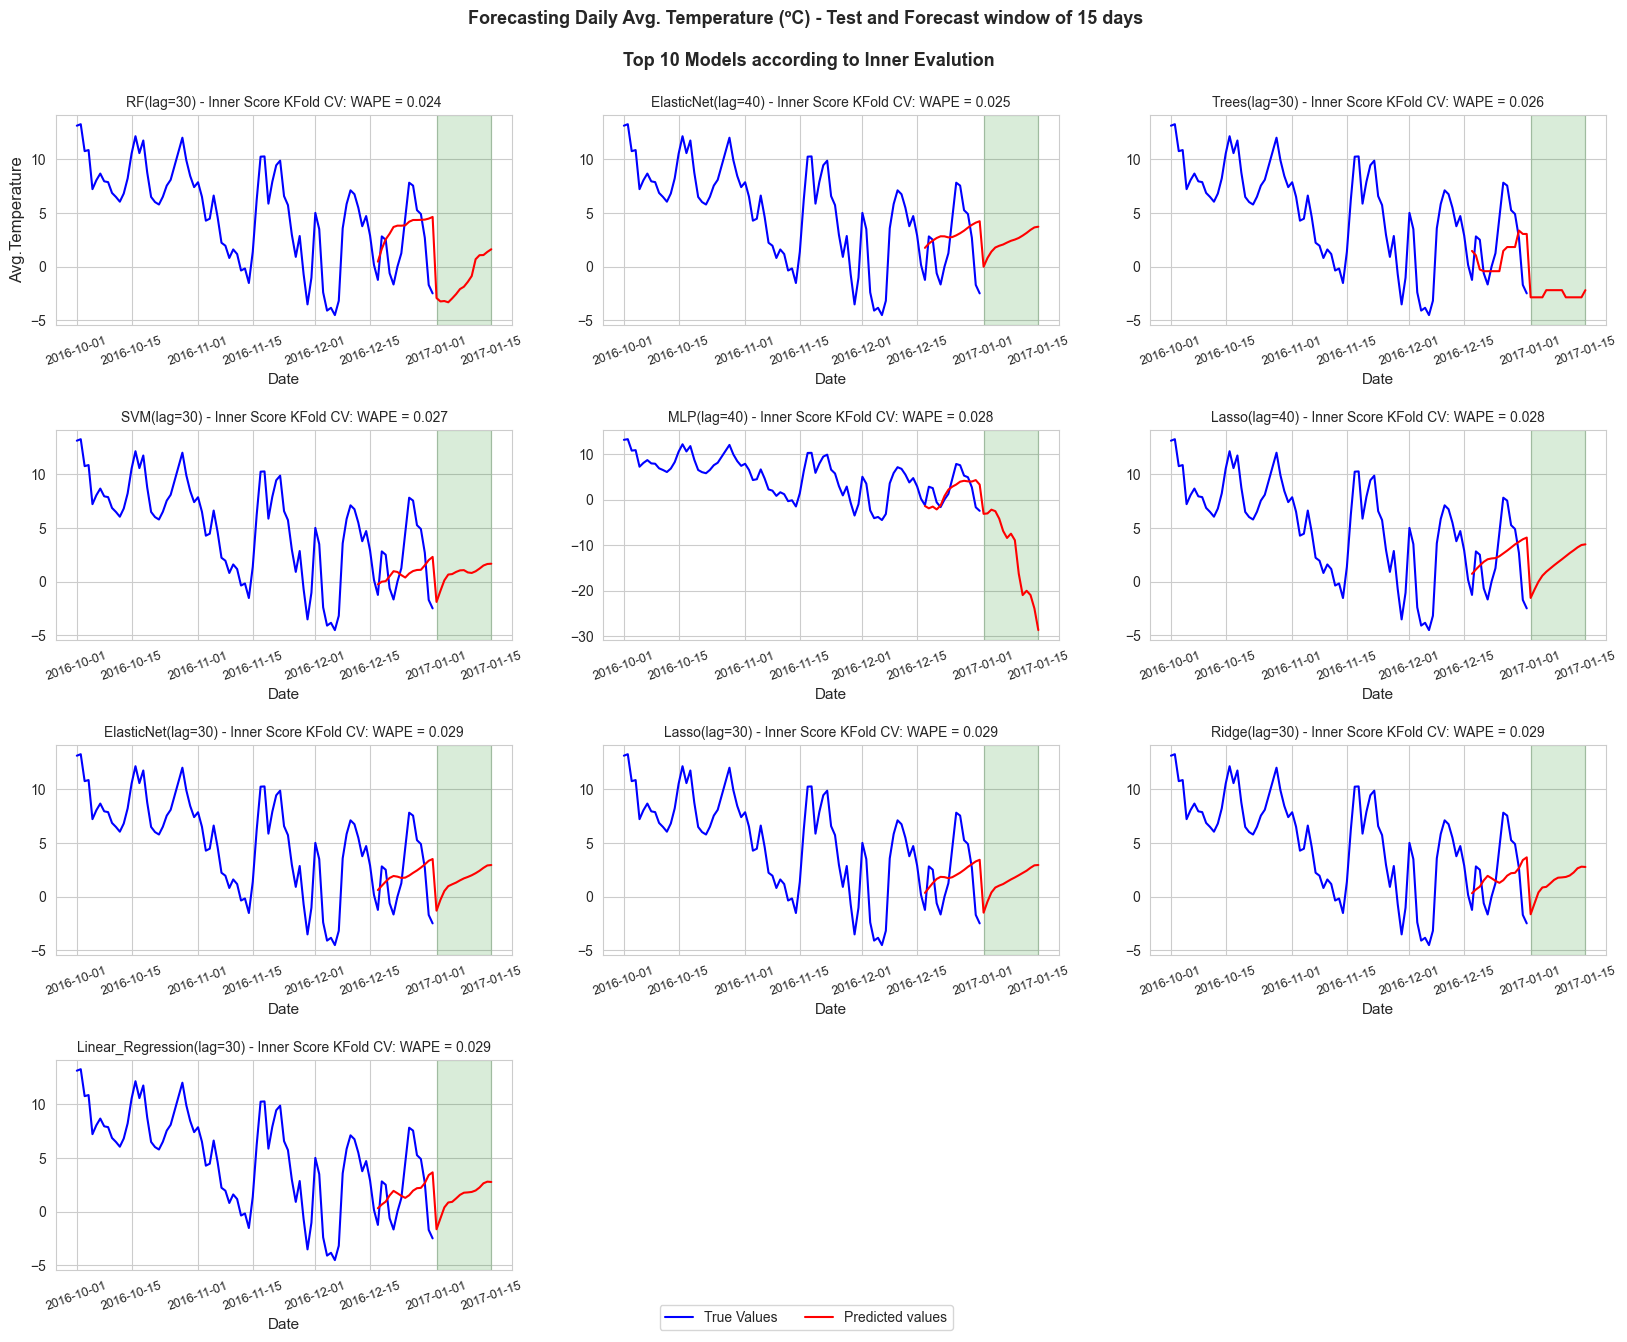

In [52]:
# Plotting test and future for the top models

predicted_values = Y_hat
prediction_dates = get_prediction_dates(dates, inner_test_window, forecast_window)

predictive_time_series_plot(n_cols=3, figsize=(20,15), 
                            data=df['T'].filter(pl.col('year')==2016, pl.col('month').is_in([10, 11, 12])), 
                            x_name='date', y_name='T', true_color='blue', pred_color='red',
                            predicted_values=predicted_values, prediction_dates=prediction_dates, test_window=inner_test_window, 
                            scores=best_score, score_name='Inner Score KFold CV: WAPE',
                            title=f"Forecasting Daily Avg. Temperature (ºC) - Test and Forecast window of {forecast_window} days\n\n Top {top} Models according to Inner Evalution", 
                            title_size=13, title_weight='bold', subtitles_size=10,
                            marker='', markersize=5, ylabel='Avg.Temperature', xlabel='Date',
                            xticks_size=9, hspace=0.5, wspace=0.2, xticks_rotation=20, xlabel_size=11, ylabel_size=11,
                            title_height=0.95, shadow_alpha=0.15, shadow_color='green', legend_size=10, bbox_to_anchor=(0.5,0.065))
